In [1]:
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from matplotlib import gridspec
import matplotlib.dates as mdates

import json
import tkp.db
import tkp.config
import logging
import csv
import time
import sys
import itertools

import numpy as np
import pandas as pd
import scipy as sp
import healpy as hp
import datetime
import os
import glob
from astropy import units as u
from astropy.coordinates import SkyCoord, match_coordinates_sky
from astropy.io import fits
from astropy.wcs import WCS

import numbers
import math
import scipy
from scipy.stats import norm
from scipy.stats import sem
from scipy import linspace
from scipy import pi,sqrt,exp
from scipy.special import erf

import pylab

from matplotlib.ticker import NullFormatter
from matplotlib.font_manager import FontProperties

plt.rcParams['font.size']=16
plt.rcParams['axes.labelsize']='large'
plt.rcParams['axes.titlesize']='large'
pylab.rcParams['legend.loc'] = 'best'
matplotlib.rcParams['text.usetex'] = False

%matplotlib inline

logging.basicConfig(level=logging.INFO)

import warnings
warnings.filterwarnings('ignore')

RuntimeError: module compiled against API version 0xc but this version of numpy is 0xa

/afhome/kuiack/newtrap/local/lib/python2.7/site-packages/pyfits/__init__.py:22: PyFITSDeprecationWarning: PyFITS is deprecated, please use astropy.io.fits
  PyFITSDeprecationWarning)  # noqa


<IPython.core.display.Javascript object>


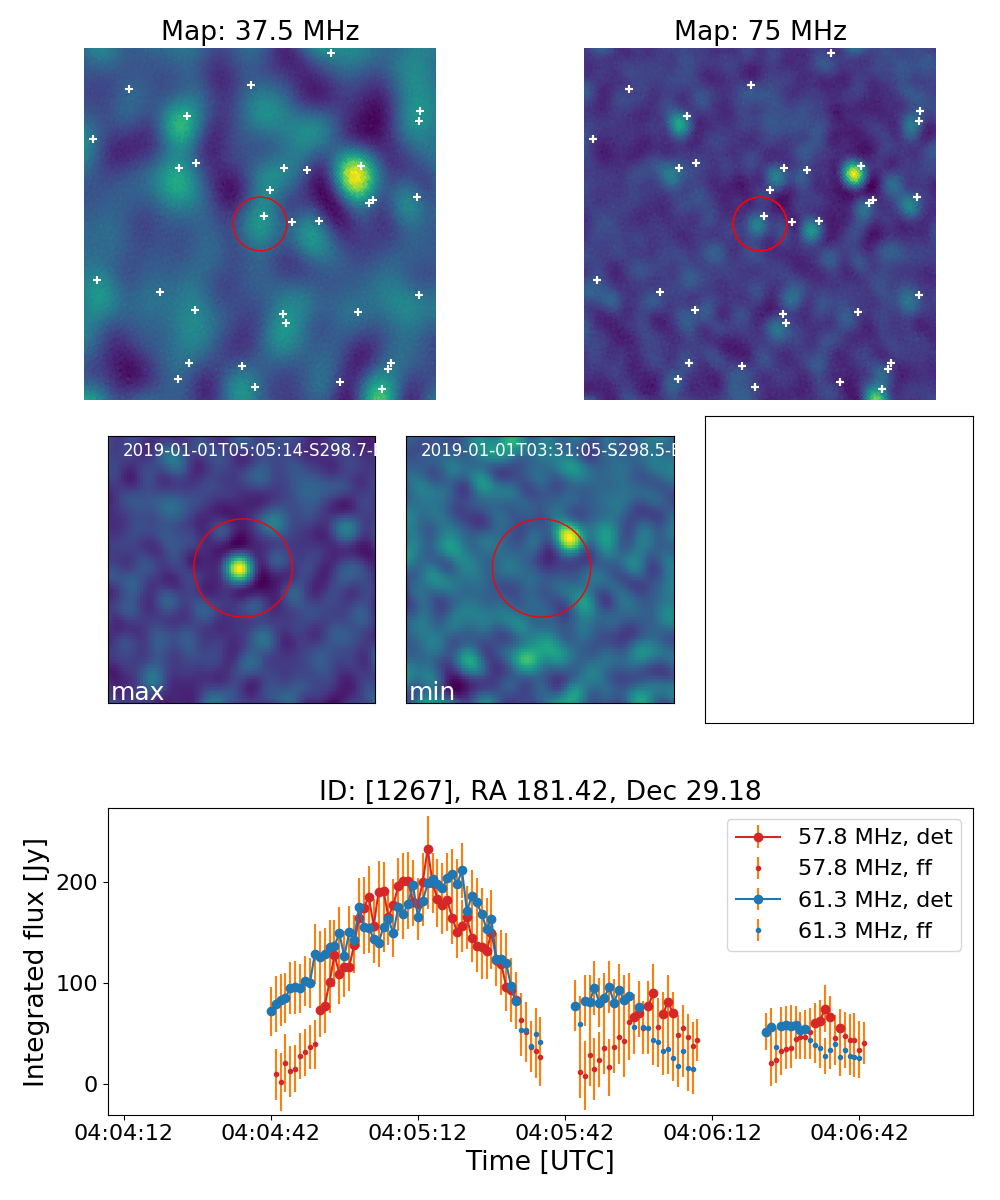

NSIDE = 512
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
NSIDE = 512
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


In [31]:
%matplotlib notebook

vlssr = pd.read_csv("/home/kuiack/VLSSr_gt_5.csv", comment="#")
tgss = pd.read_csv("/home/kuiack/TGSSADR1_7sigma_catalog.tsv", delimiter="\t")
aart = pd.read_csv("/home/kuiack/AARTFAAC_catalogue.csv")
ateam = {"ra":np.array([82.88,299.43,350.28,187.07]),"decl":np.array([21.98,40.59,58.54,12.66])}



stamp_side = 600
half_side = int(stamp_side/2)

x = np.linspace(0, stamp_side, stamp_side)
y = np.linspace(0, stamp_side, stamp_side)
x, y = np.meshgrid(x, y)


map_dir = "/home/kuiack/skymaps/"
files = glob.glob(map_dir+"*.fits")
BANDS = [os.path.basename(i)[:4] for i in files]

delta = 100 

# i = 3

# source_df = retrieve_source(data, trans_data.runcat.iloc[i])

# print trans_data.runcat.iloc[i]
# del source_df

# 2579, 2460, 1260, 1985

# run_index = 2579 #np.unique(reduced.runcatid)[653]

vlssr_thresh = 5

fig_n = 1



# for _ID in [71,794,313,3758,4132]:#np.unique(data[data.extract_type == 2].runcatid):#pass_list:#AART_catsource.index:

source_df = pd.read_csv("/data/ASASf_20190101_Candidates/CandidatePandas/1267-source_df.csv")# retrieve_source(data, _ID)

source_df.taustart_ts = pd.to_datetime(source_df.taustart_ts)



# source_df.set_index(source_df.taustart_ts, inplace=True)

base = source_df.groupby("runcatid").mean()
_ID = base.index.values

_source_flux = source_df.f_int[(source_df.freq_eff < 60000000) ].values
_index = source_df.extract_type[(source_df.freq_eff < 60000000) ].values
_source_flux[(_index == 1)] = np.nan


plt.figure(fig_n,figsize=(10,12))
map_load = hp.fitsfunc.read_map(map_dir+BANDS[2]+"_512_map.fits")
stamp = hp.gnomview(map_load,  xsize=stamp_side,
                    rot=([base.ra.values,base.decl.values]),
                    coord="C", return_projected_map=True,
                    fig=fig_n,sub=322,notext=True, title="Map: 75 MHz",cbar=False)

hp.projscatter(vlssr[vlssr.Sp > vlssr_thresh]._RAJ2000.values,
            vlssr[vlssr.Sp > vlssr_thresh]._DEJ2000.values, lonlat=True,
               marker="+", color="white", coord="C")

hp.projscatter(base.loc[_ID].ra,
               base.loc[_ID].decl,lonlat=True,
               edgecolors="red", facecolor="none", s=1500, coord="C", lw=1)

map_load = hp.fitsfunc.read_map(map_dir+BANDS[3]+"_512_map.fits")

stamp = hp.gnomview(map_load, xsize=stamp_side,
                    rot=([base.ra.values,base.decl.values]),
                    coord="C", return_projected_map=True, fig=1,sub=321, 
                    notext=True, title="Map: 37.5 MHz",cbar=False)


hp.projscatter(vlssr[vlssr.Sp > vlssr_thresh]._RAJ2000.values,
            vlssr[vlssr.Sp > vlssr_thresh]._DEJ2000.values, lonlat=True,
               marker="+", color="white", coord="C")

hp.projscatter(base.loc[_ID].ra,
               base.loc[_ID].decl,lonlat=True,
               edgecolors="red", facecolor="none", s=1500, coord="C", lw=1)


plt.subplot(313)

plt.errorbar(source_df.taustart_ts[(source_df.freq_eff < 60000000)].values,
             _source_flux, 
             yerr = source_df.f_int_err[(source_df.freq_eff < 60000000) ].values,
             fmt="o-", color="C3",ecolor="C1", label="57.8 MHz, det")

del _source_flux

if len(source_df.f_int_err[(source_df.freq_eff < 60000000) & (source_df.extract_type == 1 )].values) > 0:
    plt.errorbar(source_df.taustart_ts[(source_df.freq_eff < 60000000) & (source_df.extract_type == 1 )].values,
                 source_df.f_int[(source_df.freq_eff < 60000000) & (source_df.extract_type == 1 )].values, 
                 yerr = source_df.f_int_err[(source_df.freq_eff < 60000000) & (source_df.extract_type == 1 )].values,
                 fmt=".", color="C3",ecolor="C1", label="57.8 MHz, ff")

# plt.ylim([0,80])
_source_flux = source_df.f_int[(source_df.freq_eff > 60000000) ].values
_index = source_df.extract_type[(source_df.freq_eff > 60000000) ].values
_source_flux[(_index == 1)] = np.nan

# plt.figure(figsize=(24,8))
plt.errorbar(source_df.taustart_ts[(source_df.freq_eff > 60000000) ].values,
             _source_flux, 
             yerr = source_df.f_int_err[(source_df.freq_eff > 60000000) ].values,
             fmt="o-",color="C0", ecolor="C1", label="61.3 MHz, det")

del _source_flux

if len(source_df.f_int_err[(source_df.freq_eff > 60000000) & (source_df.extract_type == 1 )].values) > 0:
    plt.errorbar(source_df.taustart_ts[(source_df.freq_eff > 60000000) & (source_df.extract_type == 1 )].values,
                 source_df.f_int[(source_df.freq_eff > 60000000) & (source_df.extract_type == 1 )].values, 
                 yerr = source_df.f_int_err[(source_df.freq_eff > 60000000) & (source_df.extract_type == 1 )].values,
                 fmt=".", color="C0",ecolor="C1", label="61.3 MHz, ff")


plt.legend()
plt.ylabel("Integrated flux [Jy]")
plt.xlabel("Time [UTC]")
# plt.xlim([source_df.taustart_ts[source_df.freq_eff > 60000000].values[0],
#          source_df.taustart_ts[source_df.freq_eff > 60000000].values[10]])

# plt.xlim([datetime.datetime(year=2017, month=2, day=25,hour=1 , minute=48, second=0),
#           datetime.datetime(year=2017, month=2, day=25,hour=1 , minute=58, second=0)])

# plt.savefig("/home/kuiack/scintilation_source.pdf")
#     plt.tight_layout()
# plt.title("Obs: AS"+dbname+"\nID: "+str(_ID)+", RA "+str(round(source_df.ra.mean(),2))+", Dec "+str(round(source_df.decl.mean(),2)))
plt.title("\nID: "+str(_ID)+", RA "+str(round(source_df.ra.mean(),2))+", Dec "+str(round(source_df.decl.mean(),2)))


plt.subplot(3,3,4)
if  os.path.isfile(source_df[ source_df.f_int == source_df.f_int.max()].url.values[0]):
    filename = source_df[ source_df.f_int == source_df.f_int.max()].url.values[0]
else: 
    filename = "/mnt/ais001/"+source_df[ source_df.f_int == source_df.f_int.max()].url.values[0].split("/")[2]+"/"+source_df[ source_df.f_int == source_df.f_int.max()].url.values[0].split("/")[3]


wcs = WCS(filename)
im_pix_x, im_pix_y, n, nn = wcs.wcs_world2pix(source_df.ra.mean(),source_df.decl.mean(),1,1,1)

pos = [im_pix_x, im_pix_y]

plt.text(5,92,os.path.basename(filename), color="white", fontsize=12)
plt.text(0.5,0.5,"max", color="white", fontsize=18)
plt.imshow(fits.open(filename)[0].data[0,0,pos[1]-delta/2:pos[1]+delta/2,pos[0]-delta/2:pos[0]+delta/2], origin="lower")
plt.scatter(delta/2,delta/2, s=50*delta, facecolor="none", edgecolor="red")

plt.xticks([])
plt.yticks([])

plt.subplot(3,3,5)
if  os.path.isfile(source_df[ source_df.f_int == source_df.f_int.min()].url.values[0]):
    filename = source_df[ source_df.f_int == source_df.f_int.min()].url.values[0]
else: 
    filename = "/mnt/ais001/"+source_df[ source_df.f_int == source_df.f_int.min()].url.values[0].split("/")[2]+"/"+source_df[ source_df.f_int == source_df.f_int.min()].url.values[0].split("/")[3]

wcs = WCS(filename)
im_pix_x, im_pix_y, n, nn = wcs.wcs_world2pix(source_df.ra.mean(),source_df.decl.mean(),1,1,1)

pos = [im_pix_x, im_pix_y]

plt.text(5,92,os.path.basename(filename), color="white", fontsize=12)
plt.text(0.5,0.5,"min", color="white", fontsize=18)
plt.imshow(fits.open(filename)[0].data[0,0,pos[1]-delta/2:pos[1]+delta/2,pos[0]-delta/2:pos[0]+delta/2], origin="lower")
plt.scatter(delta/2,delta/2, s=50*delta, facecolor="none", edgecolor="red")
plt.xticks([])
plt.yticks([])

plt.subplot(3,3,6)
plt.plot()
plt.xticks([])
plt.yticks([])

#     plt.figure(figsize=(10,8))
#     plt.title(str(_ID)+" v_int")
#     plt.plot(source_df.v_int[(source_df.freq_eff < 60000000)], ".",label="57.8 MHz")
#     plt.plot(source_df.v_int[(source_df.freq_eff > 60000000)], ".",label="61.3 MHz")
#     plt.legend()

#     plt.figure(figsize=(10,8))
#     plt.title(str(_ID)+" eta")
#     plt.plot(source_df.eta_int[(source_df.freq_eff < 60000000)], ".", label="57.8 MHz")
#     plt.plot(source_df.eta_int[(source_df.freq_eff > 60000000)], ".", label="61.3 MHz")
#     plt.legend()
plt.tight_layout()
plt.show()
fig_n +=1
#     plt.figure(figsize=(12,6))
#     plt.plot(source_df.taustart_ts[(source_df.freq_eff > 60000000) ].values,
#                  source_df.v_int[(source_df.freq_eff > 60000000) ].values, 
#                  color="C5",  label="High band, det")
#     plt.ylabel("V_int")
#     plt.xlabel("Time [UTC]")
#     # plt.xlim([datetime.datetime(year=2017, month=2, day=25,hour=3 , minute=48, second=0),
#     #           datetime.datetime(year=2017, month=2, day=25,hour=4 , minute=10, second=0)])


#     # if _ID == 2578:
#     #     plt.ylim([0,300])

#     # del source_df       
#     #     
#     plt.show()



In [11]:
stamp = hp.gnomview(map_load,  xsize=stamp_side,
                    rot=([base.ra.values,base.decl.values]),
                    coord="C", return_projected_map=True,
                    fig=fig_n,sub=322,notext=True, title="Map: 75 MHz",cbar=False)


<IPython.core.display.Javascript object>


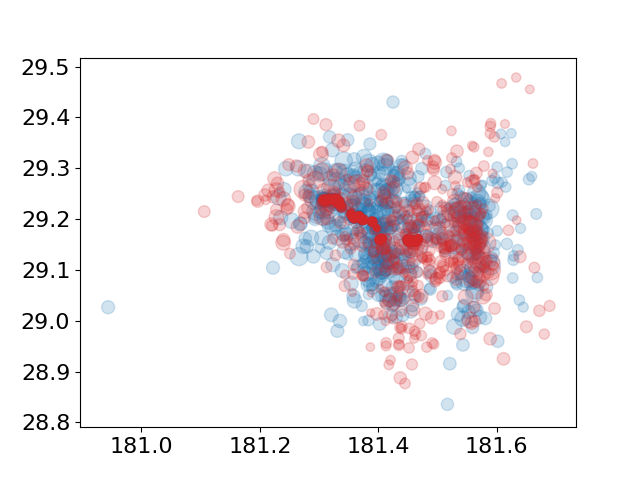

In [32]:
plt.figure()
plt.scatter(source_df[(source_df.freq_eff > 60000000) ].ra,
            source_df[(source_df.freq_eff > 60000000) ].decl,
            source_df[(source_df.freq_eff > 60000000) ].f_int,c="C0", alpha=0.2)

plt.scatter(source_df[(source_df.freq_eff < 60000000) ].ra,
         source_df[(source_df.freq_eff < 60000000) ].decl,
         source_df[(source_df.freq_eff < 60000000) ].f_int, c="C3", alpha=0.2)

In [20]:
print "/mnt/ais001/"
print source_df[ source_df.f_int == source_df.f_int.max()].url.values[0].split("/")[2]
print "/"+source_df[ source_df.f_int == source_df.f_int.max()].url.values[0].split("/")[3]



/mnt/ais001/
AS_201609051647
/2016-09-05T18:50:40-S296-B8.fits


In [17]:
source_df[ source_df.f_int == source_df.f_int.max()].url.values[0]

'/data/AS_201609051647/2016-09-05T18:50:40-S296-B8.fits'

In [34]:
plt.plot(source_df.f_int)

In [5]:
source_df

,band,decl,decl_err,det_sigma,eta_int,extract_type,f_datapoints,f_int,f_int_err,f_peak,...,ra_err,rms_max,rms_min,runcatid,tau_time,taustart_ts,url,v_int,xtrsrc,round_times
0,23,26.661712,0.129438,5.120789,0.000000,0,1,37.245281,12.526542,35.840949,...,0.130809,83.252330,4.591728,2362,1.0,2016-09-05 18:12:41,/data/AS_201609051647/2016-09-05T18:12:41-S296...,0.000000,443178,2016-09-05 18:12:41
1,24,26.661712,0.431663,2.149219,0.000000,1,1,-7.182454,8.068200,-4.161395,...,0.436815,24.385686,2.682582,2362,1.0,2016-09-05 18:12:42,/data/AS_201609051647/2016-09-05T18:12:42-S314...,-0.000000,443456,2016-09-05 18:12:42
2,24,26.661712,0.648273,2.249714,0.047984,1,2,-4.702670,7.940934,-0.232980,...,0.656653,21.105197,2.450712,2362,1.0,2016-09-05 18:12:43,/data/AS_201609051647/2016-09-05T18:12:43-S314...,-0.295070,443541,2016-09-05 18:12:43
3,24,26.661712,0.546340,2.098293,0.024605,1,3,-5.581486,7.939395,-1.817018,...,0.553143,22.096455,2.513939,2362,1.0,2016-09-05 18:12:44,/data/AS_201609051647/2016-09-05T18:12:44-S314...,-0.215948,443628,2016-09-05 18:12:44
4,24,26.661712,1.250502,2.321468,0.060949,1,4,-2.441383,7.972775,6.237460,...,1.270094,22.095800,2.742149,2362,1.0,2016-09-05 18:12:45,/data/AS_201609051647/2016-09-05T18:12:45-S314...,-0.397371,443867,2016-09-05 18:12:45
5,23,26.661712,0.409464,3.939604,3.123625,1,2,9.169321,9.769333,5.699785,...,0.414304,37.331846,3.129145,2362,1.0,2016-09-05 18:12:45,/data/AS_201609051647/2016-09-05T18:12:45-S296...,0.855451,443805,2016-09-05 18:12:45
6,24,26.661712,0.914593,1.966924,0.051776,1,5,-3.517810,8.390034,3.152312,...,0.927515,25.140573,2.447873,2362,1.0,2016-09-05 18:12:46,/data/AS_201609051647/2016-09-05T18:12:46-S314...,-0.391204,444041,2016-09-05 18:12:46
7,23,26.661712,1.356848,2.458422,3.570739,1,3,-2.203545,7.811572,7.027134,...,1.378760,17.742485,2.262958,2362,1.0,2016-09-05 18:12:46,/data/AS_201609051647/2016-09-05T18:12:46-S296...,1.377838,443978,2016-09-05 18:12:46
8,24,26.661712,0.572680,2.611930,0.046136,1,6,-6.227223,9.285921,-1.611558,...,0.579868,27.219922,2.418137,2362,1.0,2016-09-05 18:12:47,/data/AS_201609051647/2016-09-05T18:12:47-S314...,-0.355325,444216,2016-09-05 18:12:47
9,23,26.661712,0.670766,2.563680,3.005523,1,4,-4.822165,8.425957,0.085502,...,0.679493,16.974549,2.682105,2362,1.0,2016-09-05 18:12:47,/data/AS_201609051647/2016-09-05T18:12:47-S296...,1.954723,444154,2016-09-05 18:12:47


In [21]:
files = glob.glob("/mnt/ais001/AS_20160905_1SB/*S295*.fits")[-10:]
print files
for i in files:
    try:
        fits.open(i)
    except IOError:
        print i
    

['/mnt/ais001/AS_20160905_1SB/2016-09-05T17:07:48-S295-B1.fits', '/mnt/ais001/AS_20160905_1SB/2016-09-05T17:05:15-S295-B1.fits', '/mnt/ais001/AS_20160905_1SB/2016-09-05T16:53:45-S295-B1.fits', '/mnt/ais001/AS_20160905_1SB/2016-09-05T17:06:12-S295-B1.fits', '/mnt/ais001/AS_20160905_1SB/2016-09-05T16:50:46-S295-B1.fits', '/mnt/ais001/AS_20160905_1SB/2016-09-05T16:52:27-S295-B1.fits', '/mnt/ais001/AS_20160905_1SB/2016-09-05T16:48:13-S295-B1.fits', '/mnt/ais001/AS_20160905_1SB/2016-09-05T17:02:56-S295-B1.fits', '/mnt/ais001/AS_20160905_1SB/2016-09-05T17:02:21-S295-B1.fits', '/mnt/ais001/AS_20160905_1SB/2016-09-05T16:58:56-S295-B1.fits']


## Get all candidates from Candidates 

In [4]:
candidates = glob.glob("/data/ASASf_20190101_Candidates/CandidatePandas/*.csv")

In [17]:
positions = []


for cand in candidates:
    
    cand_df = pd.read_csv(cand)
    positions.append([cand_df.ra.median(),cand_df.decl.median()])
    

In [18]:
vlssr = pd.read_csv("/home/kuiack/VLSSr_gt_10.csv", comment="#")
# tgss = pd.read_csv("/home/kuiack/TGSSADR1_7sigma_catalog.tsv", delimiter="\t")
aart = pd.read_csv("/home/kuiack/AARTFAAC_catalogue.csv")

for i in range(len(aart)):
    positions.append([aart.loc[i].ra,aart.loc[i].decl])
    
# for i in range(len(vlssr)):
#     positions.append([vlssr.loc[i]._RAJ2000,vlssr.loc[i]._DEJ2000])  


In [22]:
print np.shape(np.array(positions))

positions

(271, 2)


[[111.502724531, 31.4800427925],
 [159.943659358, 31.819325660300002],
 [92.3408040761, 64.6243619292],
 [157.288877912, 14.78074778305],
 [164.318994116, 27.627462215],
 [144.118037889, 39.4280735726],
 [109.235693494, 45.491920329349995],
 [321.345538265, 84.2726986242],
 [155.432050113, 31.445181274],
 [194.864902218, 80.5892492877],
 [111.429002772, 31.302260267999998],
 [154.10743612, 40.5576153338],
 [132.409927515, 53.6824529092],
 [164.87413033200002, 19.672987477],
 [106.973234777, 38.1445116018],
 [201.91591045849998, 22.4144461356],
 [125.415418784, 52.3848788684],
 [200.50632829900002, 42.4156928835],
 [144.48935587, 25.1556026229],
 [359.110859965, 80.4260862368],
 [321.036504985, 84.2851016635],
 [80.1582608847, 50.9752101583],
 [160.72197851750002, 2.402283182435],
 [195.31241614799998, 39.994301633],
 [123.503979136, 35.5972966932],
 [202.96720439400002, 24.7499540366],
 [172.506454599, 9.71145952457],
 [261.188153941, 73.7253907521],
 [175.722618038, 5.353890138805],
 

In [21]:
positions

# outfile = "/home/kuiack/TR_20190101_monitor.json"

with open("/home/kuiack/TR_20190101_monitor.json",'w') as outfile:
    json.dump(positions,outfile)